In [1]:
pip install opencv-python


Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install keras-tuner


Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
     |████████████████████████████████| 176 kB 70.9 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [3]:
!pip install jupyterlab-system-monitor


Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
     |████████████████████████████████| 63 kB 677 kB/s eta 0:00:011
     |████████████████████████████████| 56 kB 670 kB/s eta 0:00:011
     |████████████████████████████████| 282 kB 55.3 MB/s eta 0:00:01


In [15]:
import numpy as np
import pandas as pd
import cv2
import os
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, concatenate
from sklearn.model_selection import train_test_split
from keras_tuner.tuners import RandomSearch

# load train dataset
train_df = pd.read_csv('data/training_norm.csv')
train_images = []
for image_id in train_df['image_id']:
    image = cv2.imread(f'data/training_data/training_data/{image_id}.png')
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    train_images.append(image)
train_images = np.array(train_images)
train_angles = np.array(train_df['angle'])
train_speeds = np.array(train_df['speed'])

# load test dataset
test_images = []
for i in range(1, 1021):
    image = cv2.imread(f'data/test_data/test_data/{i}.png')
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    test_images.append(image)
test_images = np.array(test_images)
test_ids = np.arange(1, 1021)

# split the data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(train_images, train_df[['angle', 'speed']].values, test_size=0.2, random_state=42)

# define the early stopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

# define the model
def build_model(hp):
    # input layer
    input_layer = Input(shape=(240, 320, 3))

    # convolutional layers
    num_conv_layers = hp.Int('num_conv_layers', min_value=2, max_value=5, step=1)
    conv_layer_filters = [hp.Choice(f'conv_layer_{i}_filters', values=[32, 64, 128, 256], ordered=False, default=64) for i in range(num_conv_layers)]
    conv_layer_kernel_sizes = [hp.Choice(f'conv_layer_{i}_kernel_sizes', values=[3, 5, 7], ordered=False, default=3) for i in range(num_conv_layers)]
    conv_layer_activations = [hp.Choice(f'conv_layer_{i}_activations', values=['relu', 'elu'], default='relu') for i in range(num_conv_layers)]
    x = input_layer
    for i in range(num_conv_layers):
        x = Conv2D(filters=conv_layer_filters[i], kernel_size=conv_layer_kernel_sizes[i], activation=conv_layer_activations[i], padding='same')(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)

    # fully connected layers
    x = Flatten()(x)
    num_dense_layers = hp.Int('num_dense_layers', min_value=1, max_value=3, step=1)
    for i in range(num_dense_layers):
        dense_layer_units = hp.Int(f'dense_layer_{i}_units', min_value=32, max_value=512, step=32)
        dense_layer_activation = hp.Choice(f'dense_layer_{i}_activation', values=['relu', 'elu'], default='relu')
        x = Dense(units=dense_layer_units, activation=dense_layer_activation)(x)
        dropout_rate = hp.Float(f'dropout_{i}', min_value=0.0, max_value=0.5, step=0.1, default=0.25)
        x = Dropout(rate=dropout_rate)(x)

    # output layer
    angle_output = Dense(units=1, name='angle_output')(x)
    speed_output = Dense(units=1, name='speed_output')(x)
    model = Model(inputs=input_layer, outputs=[angle_output, speed_output])

    # compile the model
    optimizer = Adam(learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log'))
    loss = {'angle_output': 'mean_squared_error', 'speed_output': 'mean_squared_error'}
    metrics = {'angle_output': 'mae', 'speed_output': 'mae'}
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    return model

# define the tuner
tuner = RandomSearch(
build_model,
objective='val_loss',
max_trials=50,
directory='output',
project_name='steering_angle_regression'
)

# search for the best hyperparameters
tuner.search(X_train, y_train, epochs=50, validation_data=(X_val, y_val), callbacks=[early_stop])

# get the best model
best_model = tuner.get_best_models(num_models=1)[0]
best_model.save('keras_tuner_model_50trials.h5')


# train the model on the entire training dataset
history = best_model.fit(train_images, [train_angles, train_speeds], epochs=100, batch_size=32, validation_split=0.2)

# make predictions on the test set
test_predictions = best_model.predict(test_images)


# create submission file
submission_df = pd.DataFrame({'ID': test_ids, 'steering_angle': test_predictions[0].flatten(), 'speed': test_predictions[1].flatten()})
submission_df.to_csv('submission_keras_tuner_50 trials.csv', index=False)

Trial 50 Complete [00h 10m 58s]
val_loss: 0.16642504930496216

Best val_loss So Far: 0.1284092366695404
Total elapsed time: 08h 36m 02s
INFO:tensorflow:Oracle triggered exit
Epoch 1/100
345/345 [==============================] - 45s 128ms/step - loss: 0.0445 - angle_output_loss: 0.0187 - speed_output_loss: 0.0258 - angle_output_mae: 0.1025 - speed_output_mae: 0.1066 - val_loss: 0.0227 - val_angle_output_loss: 0.0099 - val_speed_output_loss: 0.0128 - val_angle_output_mae: 0.0725 - val_speed_output_mae: 0.0527
Epoch 2/100
345/345 [==============================] - 44s 126ms/step - loss: 0.0244 - angle_output_loss: 0.0109 - speed_output_loss: 0.0135 - angle_output_mae: 0.0783 - speed_output_mae: 0.0790 - val_loss: 0.0169 - val_angle_output_loss: 0.0072 - val_speed_output_loss: 0.0097 - val_angle_output_mae: 0.0629 - val_speed_output_mae: 0.0448
Epoch 3/100
345/345 [==============================] - 44s 126ms/step - loss: 0.0199 - angle_output_loss: 0.0095 - speed_output_loss: 0.0104 - ang

In [11]:
print("test_ids shape:", test_ids.shape)
print("test_predictions[0] shape:", test_predictions[0].flatten().shape)
print("test_predictions[1] shape:", test_predictions[1].flatten().shape)


test_ids shape: (1020,)
test_predictions[0] shape: (1020,)
test_predictions[1] shape: (1020,)


In [16]:
#print the best model architecture
best_model = tuner.get_best_models(num_models=1)[0]
tuner.get_best_hyperparameters()[0].values

{'num_conv_layers': 5,
 'conv_layer_0_filters': 256,
 'conv_layer_1_filters': 32,
 'conv_layer_0_kernel_sizes': 7,
 'conv_layer_1_kernel_sizes': 5,
 'conv_layer_0_activations': 'elu',
 'conv_layer_1_activations': 'elu',
 'num_dense_layers': 3,
 'dense_layer_0_units': 64,
 'dense_layer_0_activation': 'elu',
 'dropout_0': 0.2,
 'learning_rate': 0.0002364608930541925,
 'conv_layer_2_filters': 256,
 'conv_layer_3_filters': 256,
 'conv_layer_2_kernel_sizes': 3,
 'conv_layer_3_kernel_sizes': 3,
 'conv_layer_2_activations': 'relu',
 'conv_layer_3_activations': 'relu',
 'dense_layer_1_units': 448,
 'dense_layer_1_activation': 'elu',
 'dropout_1': 0.2,
 'dense_layer_2_units': 96,
 'dense_layer_2_activation': 'relu',
 'dropout_2': 0.2,
 'conv_layer_4_filters': 256,
 'conv_layer_4_kernel_sizes': 7,
 'conv_layer_4_activations': 'relu'}

In [17]:
#print the best hyperparameters values
best_hyperparameters = tuner.get_best_hyperparameters()[0].values
print("Best hyperparameters:")
for key, value in best_hyperparameters.items():
    print(f"{key}: {value}")


Best hyperparameters:
num_conv_layers: 5
conv_layer_0_filters: 256
conv_layer_1_filters: 32
conv_layer_0_kernel_sizes: 7
conv_layer_1_kernel_sizes: 5
conv_layer_0_activations: elu
conv_layer_1_activations: elu
num_dense_layers: 3
dense_layer_0_units: 64
dense_layer_0_activation: elu
dropout_0: 0.2
learning_rate: 0.0002364608930541925
conv_layer_2_filters: 256
conv_layer_3_filters: 256
conv_layer_2_kernel_sizes: 3
conv_layer_3_kernel_sizes: 3
conv_layer_2_activations: relu
conv_layer_3_activations: relu
dense_layer_1_units: 448
dense_layer_1_activation: elu
dropout_1: 0.2
dense_layer_2_units: 96
dense_layer_2_activation: relu
dropout_2: 0.2
conv_layer_4_filters: 256
conv_layer_4_kernel_sizes: 7
conv_layer_4_activations: relu


In [18]:
#model structure
from tensorflow.keras.utils import plot_model
plot_model(best_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)


('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


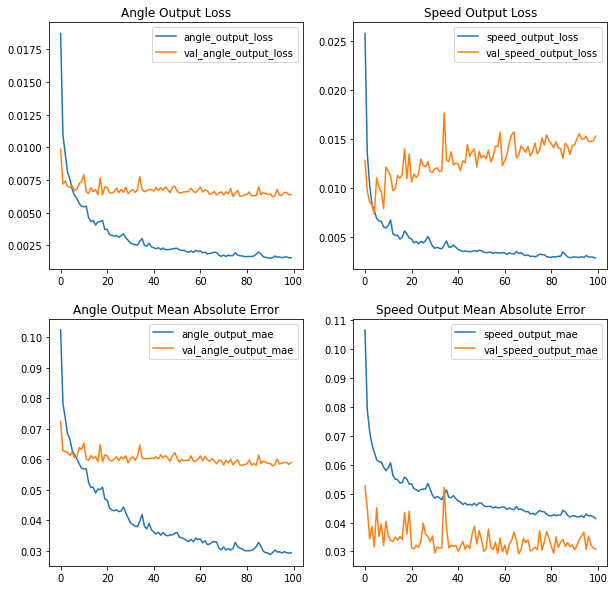

In [19]:
#training process
import matplotlib.pyplot as plt

def plot_history(history):
    fig, axs = plt.subplots(2, 2, figsize=(10, 10))
    axs[0, 0].plot(history.history['angle_output_loss'], label='angle_output_loss')
    axs[0, 0].plot(history.history['val_angle_output_loss'], label='val_angle_output_loss')
    axs[0, 0].set_title('Angle Output Loss')
    axs[0, 0].legend()

    axs[0, 1].plot(history.history['speed_output_loss'], label='speed_output_loss')
    axs[0, 1].plot(history.history['val_speed_output_loss'], label='val_speed_output_loss')
    axs[0, 1].set_title('Speed Output Loss')
    axs[0, 1].legend()

    axs[1, 0].plot(history.history['angle_output_mae'], label='angle_output_mae')
    axs[1, 0].plot(history.history['val_angle_output_mae'], label='val_angle_output_mae')
    axs[1, 0].set_title('Angle Output Mean Absolute Error')
    axs[1, 0].legend()

    axs[1, 1].plot(history.history['speed_output_mae'], label='speed_output_mae')
    axs[1, 1].plot(history.history['val_speed_output_mae'], label='val_speed_output_mae')
    axs[1, 1].set_title('Speed Output Mean Absolute Error')
    axs[1, 1].legend()

    plt.show()

plot_history(history)


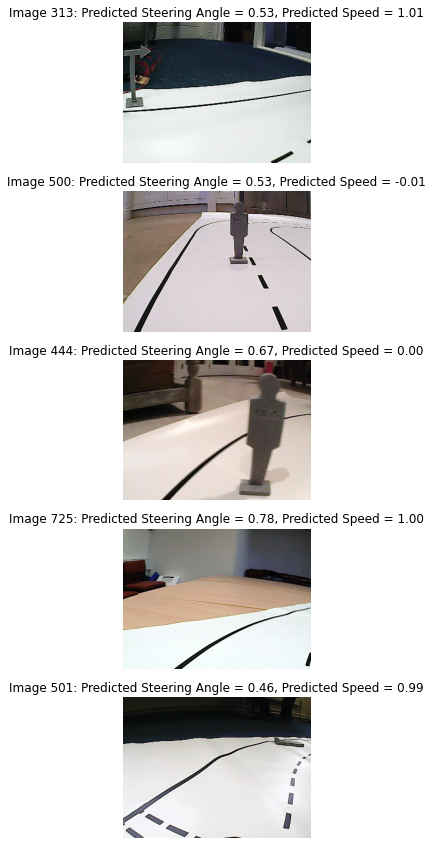

In [20]:
#display test predictions
import matplotlib.pyplot as plt

def display_test_predictions(test_images, test_predictions, num_images=5):
    indices = np.random.choice(len(test_images), num_images)
    fig, axs = plt.subplots(num_images, 1, figsize=(10, num_images * 3))

    for i, index in enumerate(indices):
        image = test_images[index]
        angle_prediction = test_predictions[0][index][0]
        speed_prediction = test_predictions[1][index][0]

        axs[i].imshow(image)
        axs[i].axis('off')
        axs[i].set_title(f'Image {index + 1}: Predicted Steering Angle = {angle_prediction:.2f}, Predicted Speed = {speed_prediction:.2f}')

    plt.show()

display_test_predictions(test_images, test_predictions)


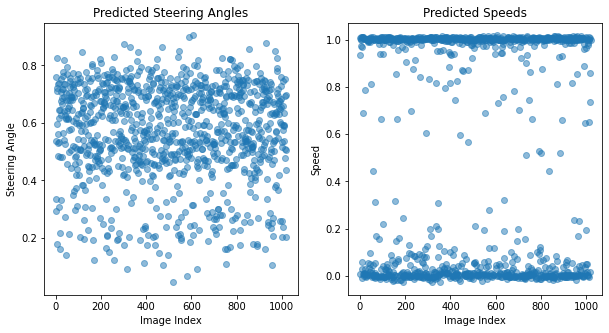

In [21]:
import matplotlib.pyplot as plt

def plot_predictions(test_predictions):
    angle_predictions = test_predictions[0].flatten()
    speed_predictions = test_predictions[1].flatten()
    
    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 2, 1)
    plt.scatter(range(len(angle_predictions)), angle_predictions, label="Predicted Steering Angles", alpha=0.5)
    plt.xlabel("Image Index")
    plt.ylabel("Steering Angle")
    plt.title("Predicted Steering Angles")
    
    plt.subplot(1, 2, 2)
    plt.scatter(range(len(speed_predictions)), speed_predictions, label="Predicted Speeds", alpha=0.5)
    plt.xlabel("Image Index")
    plt.ylabel("Speed")
    plt.title("Predicted Speeds")
    
    plt.show()

plot_predictions(test_predictions)


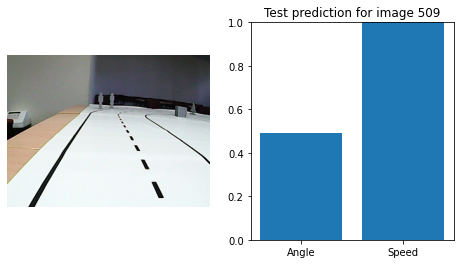

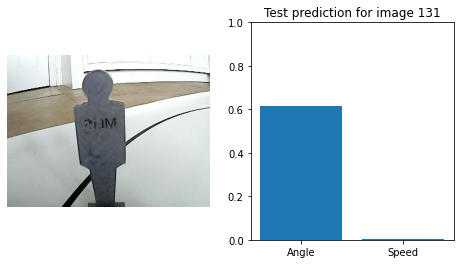

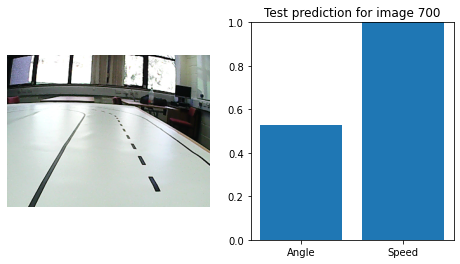

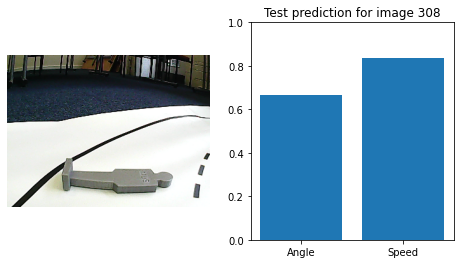

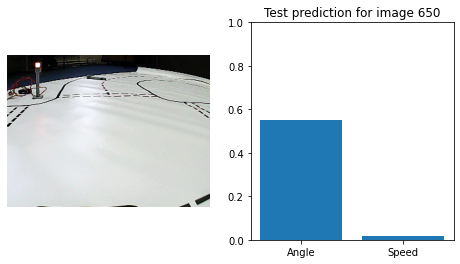

In [24]:
import matplotlib.pyplot as plt

def display_test_predictions(test_images, test_predictions, num_images=5):
    indices = np.random.choice(len(test_images), num_images)

    for i, index in enumerate(indices):
        image = test_images[index]
        angle_prediction = test_predictions[0][index][0]
        speed_prediction = test_predictions[1][index][0]

        plt.figure(figsize=(8, 4))
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.axis('off')
        plt.subplot(1, 2, 2)
        plt.bar(['Angle', 'Speed'], [angle_prediction, speed_prediction])
        plt.ylim(0, 1)
        plt.title(f"Test prediction for image {index + 1}")
        plt.show()

display_test_predictions(test_images, test_predictions)


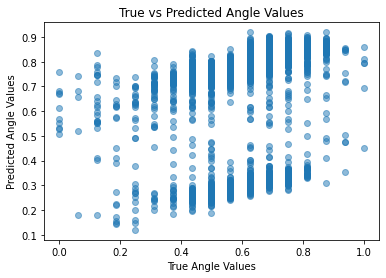

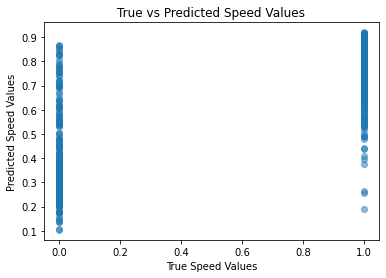

In [26]:
y_pred = best_model.predict(X_val)  # Replace X_val with your dataset
y_true = y_val  # Replace y_val with your ground truth labels

# Plot true vs predicted values for angle output
plt.scatter(y_true[:, 0], y_pred[0].flatten(), alpha=0.5)
plt.xlabel("True Angle Values")
plt.ylabel("Predicted Angle Values")
plt.title("True vs Predicted Angle Values")
plt.show()

# Plot true vs predicted values for speed output
plt.scatter(y_true[:, 1], y_pred[1].flatten(), alpha=0.5)
plt.xlabel("True Speed Values")
plt.ylabel("Predicted Speed Values")
plt.title("True vs Predicted Speed Values")
plt.show()


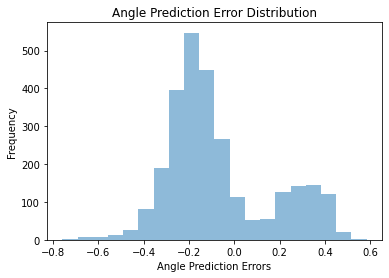

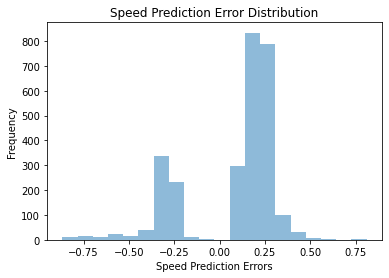

In [27]:
angle_errors = y_true[:, 0] - y_pred[0].flatten()
speed_errors = y_true[:, 1] - y_pred[1].flatten()

# Plot error distribution for angle output
plt.hist(angle_errors, bins=20, alpha=0.5)
plt.xlabel("Angle Prediction Errors")
plt.ylabel("Frequency")
plt.title("Angle Prediction Error Distribution")
plt.show()

# Plot error distribution for speed output
plt.hist(speed_errors, bins=20, alpha=0.5)
plt.xlabel("Speed Prediction Errors")
plt.ylabel("Frequency")
plt.title("Speed Prediction Error Distribution")
plt.show()


In [28]:
import pickle

# Save the training history to a file
def save_history(history, filename):
    with open(filename, 'wb') as f:
        pickle.dump(history.history, f)

# Save the history
save_history(history, 'history.pickle')




In [29]:
import json

# Save the best hyperparameters
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0].values
with open('best_hyperparameters.json', 'w') as f:
    json.dump(best_hyperparameters, f)